In [15]:
import thermalutil as tu
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
import numpy as np
import matplotlib.pyplot as plt  # Needed for clabel
import pickle as pkl

In [16]:
def preview(df_therm_data,show_sensors=False,vmin=None,vmax=None,rows=None):
    '''
    Preview the thermal data in the file through 6 plots of equally spaced time points.
    params df_therm_data: pandas dataframe containing thermal data (datetime as index, 64 columns for sensor data and potentially one more column for validity)
    '''

    # check that the df is valid
    if not isinstance(df_therm_data, pd.DataFrame):
        raise ValueError("The input is not a pandas dataframe")
    if df_therm_data.shape[1] != 65 and df_therm_data.shape[1] != 64:
        raise ValueError(f"The input dataframe does not have the correct shape (needs to be 64 or 65 columns and got {df_therm_data.shape[1]})")
    if df_therm_data.index.name != 'datetime':
        raise ValueError("The input dataframe does not have the correct index name (needs to be 'datetime')")
    if df_therm_data.iloc[:,0].name !='t00':
        raise ValueError("The input dataframe does not have the correct column names (first column should be 't00')")
    
    # iterate through a few rows
    plt.figure(); plt.clf()
    _, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 7))
    n_data_points = df_therm_data.shape[0]
    if rows is None:
        rows = np.linspace(0, n_data_points-1, 6, dtype=int)

    coords = []
    print("=====================================================================================================================================================")
    print("=====================================================================================================================================================")
    print(f"Previewing thermal data:")
    for i, row in enumerate(rows):
        temps = df_therm_data.iloc[row]
        temps_np = temps.to_numpy()
        try:
            thermalframe = tu.ThermalFrame(temperature_data=temps_np, show_sensors=show_sensors)

        except tu.NoValidSensors as e:
            print(f"Skipping row {row} due to no valid sensors")
            continue
        
        temp_field = thermalframe.calculate_thermal_field(verbose=False)

        x, y = thermalframe.get_max_temp_pos()
        coords.append((row, df_therm_data.iloc[row].name, x, y))

        print(f"Max temp at {x}, {y} for row {row} [tmax = {np.max(temp_field)}]")
        a = ax.flat[i]
        thermalframe.plot_thermal_field(a,show_cb=True,v_min=vmin,v_max=vmax)
        a.plot(x, y, 'go', markersize=4,label='Max temp')
        a.set_title(f"Row {row} -> {str(df_therm_data.iloc[row].name)}")
        a.legend(loc='upper right', fontsize=7)

                           t00        t01        t02        t03        t04        t05        t06        t07        t08        t09  ...  pwm  pwm  pwm  pwm  pwm  pwm  pwm  pwm  pwm  pwm
datetime                                                                                                                           ...                                                  
2020-12-08 10:47:59  15.171875  14.398438  13.828125  13.398438  14.593750  15.515625  17.570312  16.687500  14.093750  13.531250  ...    0    0    0    0    0    0    0    0    0    0
2020-12-08 10:48:09  15.171875  14.406250  13.828125  13.406250  14.601562  15.515625  17.570312  16.687500  14.093750  13.531250  ...    0    0    0    0    0    0    0    0  950  950
2020-12-08 10:48:19  15.171875  14.406250  13.828125  13.398438  14.593750  15.515625  17.570312  16.687500  14.093750  13.531250  ...    0    0    0    0    0    0    0    0  950  950
2020-12-08 10:48:29  15.171875  14.398438  13.828125  13.406250  14.593750 

<Figure size 640x480 with 0 Axes>

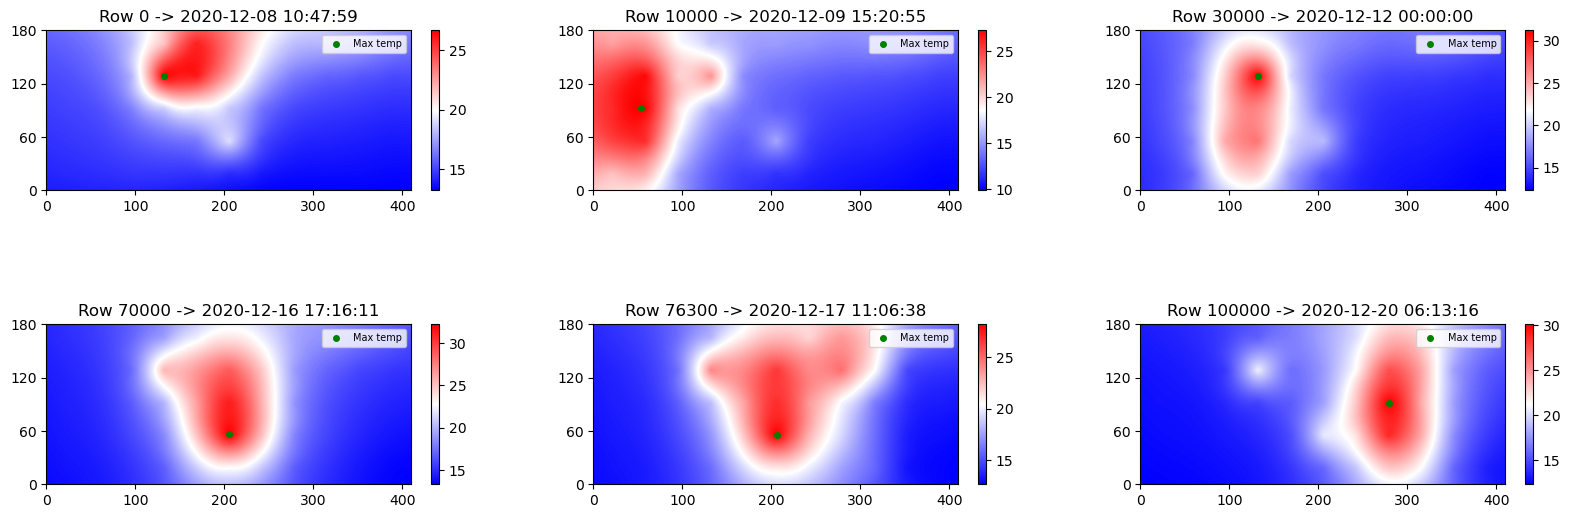

In [17]:
# Plotting data from december 2020 zigzag experiment 

file_path = '/Users/cyrilmonette/Desktop/EPFL 2018-2026/PhD - Mobots/data/20.12_actuation_OH/Thermal meas/abc_heat_201208-104759--210128-094843-utc_zigzag.dat'

df = None
try:
    # Assuming data is in a structured format like CSV or similar
    df = pd.read_csv(file_path, delimiter=',', skiprows=1, header=None)
    # make the columns as being : datetime, 64 columns for sensor data and potentially one column for validity
    df.columns = ['datetime'] + [f't{i:02d}' for i in range(64)] + ['target' for _ in range(10)] + ['h_avg_temps' for _ in range(10)] + ['pwm' for _ in range(10)]
    df.set_index('datetime', inplace=True)
    print(df)
 
except FileNotFoundError:
    print(f"File '{file_path}' not found.")

# fetch the first line of the .dat file
with open(file_path, 'r') as file:
    first_line = file.readline()
    print("First line (not in df) = " + first_line)
    second_line = file.readline()
    print("Second line (in df) = " + second_line)

temperatures = df.iloc[:, 0:64]
# rename index
temperatures.index.name = 'datetime'
# rename columns
temperatures.columns = [f't{i:02d}' for i in range(64)]
target = df.iloc[:,64:74]
print("target")
print(target.head())
print("temperatures")
print(temperatures.head())
# Only keep data before 15th January 2021 NOTE: Why ?
temperatures = temperatures.loc[:'2021-01-15']
preview(temperatures,show_sensors=False,rows=[0, 10000, 30000, 70000, 76300, 100000])

                                 t00        t01        t02        t03        t04        t05        t06        t07        t08        t09  ...        t54        t55        t56        t57        t58        t59        t60        t61        t62        t63
datetime                                                                                                                                 ...                                                                                                              
2022-01-08 00:00:01+00:00  19.531250  19.304688  19.953125  16.820312  21.265625  21.054688  19.484375  17.570312  20.335938  16.523438  ...  25.906250  33.828125  18.031250  21.476562  30.960938  33.210938  24.843750  29.156250  27.492188  25.664062
2022-01-08 00:00:11+00:00  19.539062  19.296875  19.953125  16.820312  21.265625  21.054688  19.484375  17.578125  20.250000  16.414062  ...  25.835938  33.718750  18.039062  21.484375  30.960938  33.210938  24.843750  29.148438  27.492188  25.664

<Figure size 640x480 with 0 Axes>

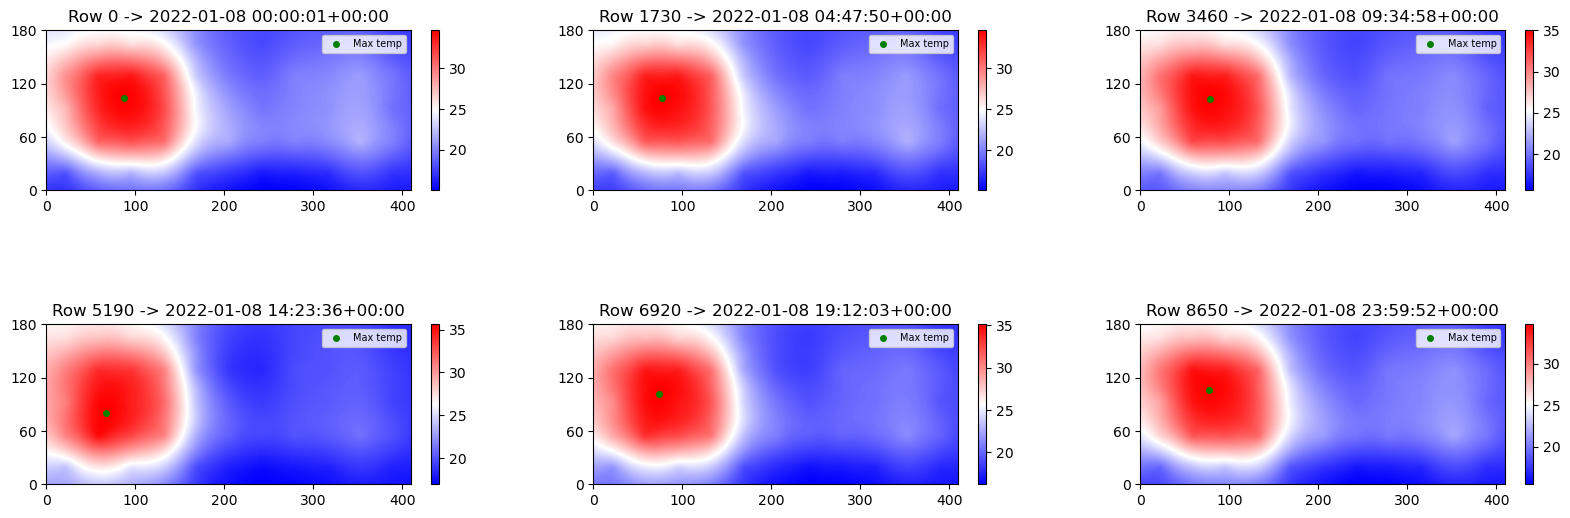

In [18]:
# Plotting data from 21-22 winter
file_path = "/Users/cyrilmonette/Desktop/EPFL 2018-2026/PhD - Mobots/data/21.11-22.05_observation_OH/Thermal meas/h4r4/tmp/abc07_tmp_2022-01-08.csv"
df = pd.read_csv(file_path, parse_dates=['datetime'])
df.drop(columns=['timestamp'], inplace=True)
df.set_index('datetime', inplace=True)
print(df)
#preview(df, show_sensors=False,rows=[1000, 2000, 3000, 4000, 5000, 6000])
preview(df, show_sensors=False)


                           t00        t01        t02        t03        t04        t05        t06        t07        t08        t09  ...        t55        t56        t57        t58        t59        t60        t61        t62        t63  validity
datetime                                                                                                                           ...                                                                                                             
2020-11-30 23:59:56  12.890625  11.804688  10.812500   9.906250  12.304688  13.515625  15.632812  14.507812  11.296875   9.828125  ...  15.273438  10.875000  11.054688  11.851562  12.617188  13.546875  12.765625  12.140625  11.515625      True
2020-12-01 00:00:56  12.882812  11.804688  10.804688   9.898438  12.296875  13.515625  15.617188  14.492188  11.296875   9.828125  ...  15.257812  10.851562  11.039062  11.828125  12.601562  13.523438  12.734375  12.117188  11.500000      True
2020-12-01 00:01:56  12.

<Figure size 640x480 with 0 Axes>

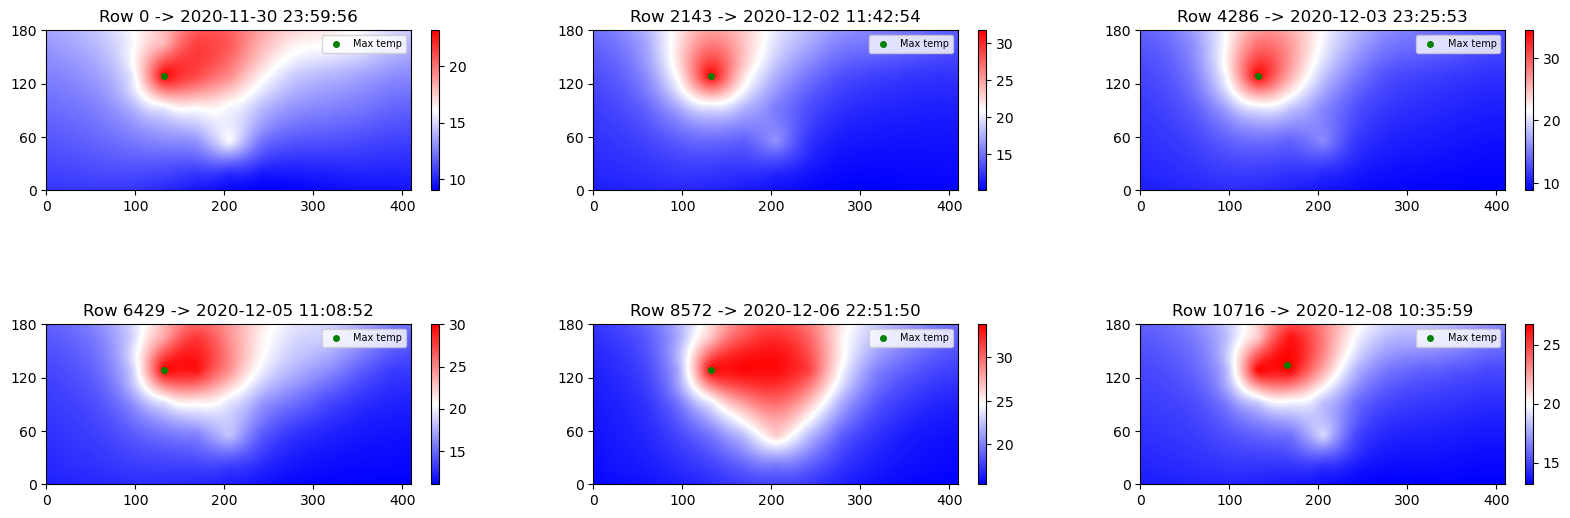

In [19]:
# Plotting data from 2020.12

file_path = "/Users/cyrilmonette/Desktop/EPFL 2018-2026/PhD - Mobots/data/20.07-20.12_observation_OH/Thermal meas/brood_2020_12.dat"
try:
    # Assuming data is in a structured format like CSV or similar
    df = pd.read_csv(file_path, delimiter=',', skiprows=1, header=None)
    # make the columns as being : datetime, 64 columns for sensor data and potentially one column for validity
    df.columns = ['datetime'] + [f't{i:02d}' for i in range(64)] + ['validity']
    df.set_index('datetime', inplace=True)
    print(df)
 
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

# fetch the first line of the .dat file
with open(file_path, 'r') as file:
    first_line = file.readline()
    print("First line (not in df) = " + first_line)

#preview(df, show_sensors=False, vmin=20, vmax=35)
preview(df, show_sensors=False)

                                  t00         t01         t02         t03         t04         t05         t06         t07         t08         t09  ...         t54         t55         t56         t57         t58         t59         t60         t61    t62         t63
datetime                                                                                                                                           ...                                                                                                                   
2022-06-14 14:18:59+00:00   27.585938   27.460938   27.375000   27.242188   27.507812   27.710938   28.835938   28.289062   27.375000   27.242188  ...   28.898438   28.062500   27.179688   27.234375   27.375000   27.601562   28.773438   27.937500 -273.0   27.335938
2022-06-14 14:19:13+00:00   27.601562   27.468750   27.375000   27.250000   27.515625   27.734375   28.859375   28.320312   27.375000   27.234375  ...   28.921875   28.070312   27.179688   27.234375   2

<Figure size 640x480 with 0 Axes>

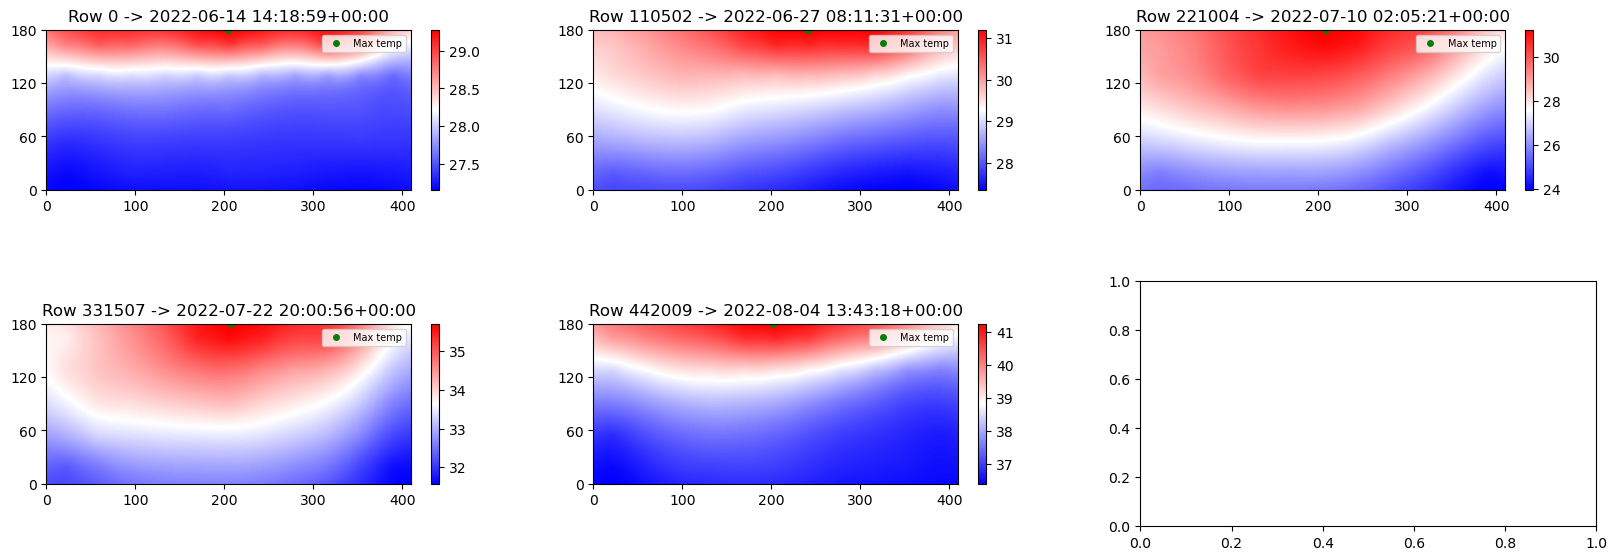

In [20]:
f_therm_data = "/Users/cyrilmonette/Desktop/EPFL 2018-2026/PhD - Mobots/data/22.06-22.10_observation_BH/Thermal meas/sry/abc10_tmp_merged-2022.csv"
df = pd.read_csv(f_therm_data, parse_dates=['datetime'])
df.drop(columns=['timestamp'], inplace=True)
df.set_index('datetime', inplace=True)
print(df)
#preview(df, show_sensors=False,rows=[1000, 2000, 3000, 4000, 5000, 6000])
preview(df, show_sensors=False)


                           t00        t01        t02        t03        t04        t05        t06        t07        t08        t09  ...        t55        t56        t57        t58        t59        t60        t61        t62        t63  validity
datetime                                                                                                                           ...                                                                                                             
2020-08-31 23:59:53  20.195312  19.835938  19.578125  19.421875  20.062500  20.500000  21.445312  20.921875  19.992188  19.609375  ...  20.359375  19.851562  19.875000  20.101562  20.109375  20.453125  20.156250  20.078125  20.015625      True
2020-09-01 00:00:53  20.187500  19.828125  19.562500  19.414062  20.062500  20.492188  21.445312  20.921875  19.992188  19.601562  ...  20.351562  19.851562  19.875000  20.093750  20.101562  20.453125  20.164062  20.070312  20.015625      True
2020-09-01 00:01:53  20.

<Figure size 640x480 with 0 Axes>

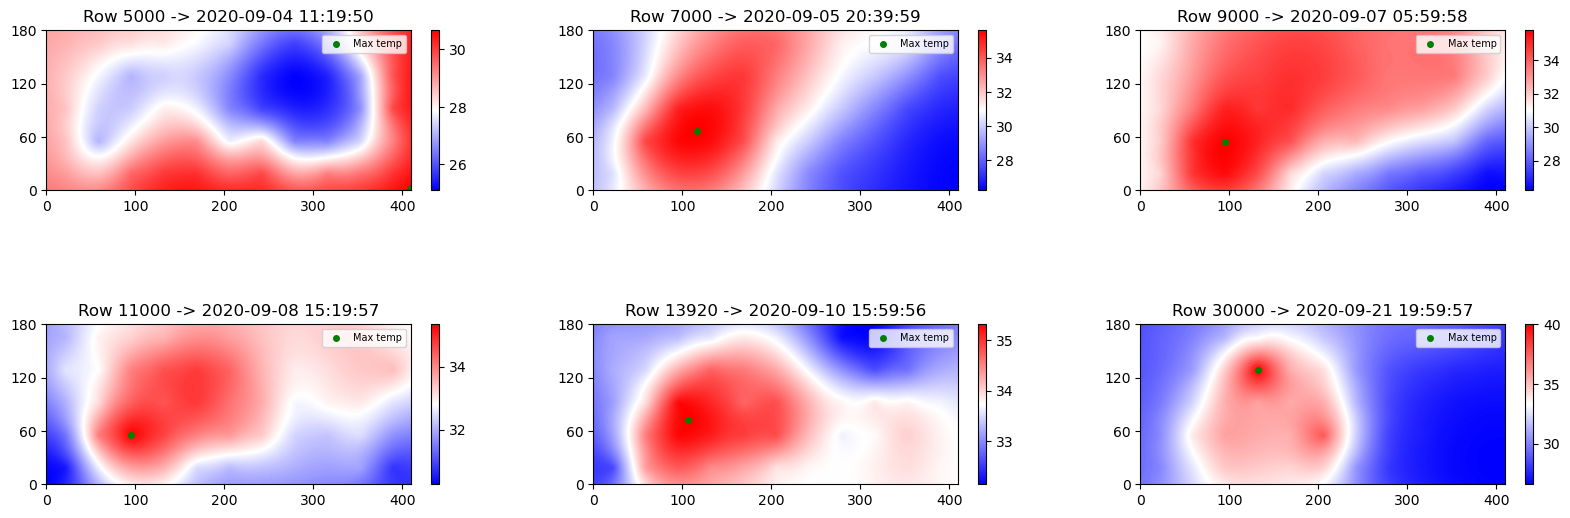

In [21]:
# Exploring the data from end of summer 2020

file_path = '/Users/cyrilmonette/Desktop/EPFL 2018-2026/PhD - Mobots/data/20.07-20.12_observation_OH/Thermal meas/brood_2020_09.dat'
  
try:
    # Assuming data is in a structured format like CSV or similar
    df = pd.read_csv(file_path, delimiter=',', skiprows=1, header=None)
    # make the columns as being : datetime, 64 columns for sensor data and potentially one column for validity
    df.columns = ['datetime'] + [f't{i:02d}' for i in range(64)] + ['validity']
    df.set_index('datetime', inplace=True)
    print(df)
 
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

# fetch the first line of the .dat file
with open(file_path, 'r') as file:
    first_line = file.readline()
    print("First line (not in df) = " + first_line)

#preview(df, show_sensors=False, vmin=20, vmax=35)
preview(df, show_sensors=False, rows=[5000, 7000, 9000, 11000, 13920, 30000])

### In the following cell, we observe the robustness of the interpolation to missing temprature values

                            timestamp        t00        t01        t02        t03        t04        t05        t06        t07        t08  ...        t54        t55        t56        t57        t58        t59        t60        t61        t62        t63
datetime                                                                                                                                  ...                                                                                                              
2022-06-27 00:00:05+00:00  1656288005  31.164062  29.523438  27.601562  26.109375  30.890625  33.382812  33.625000  31.851562  29.820312  ...  33.507812  34.812500  27.492188  28.515625  32.015625  34.617188  31.390625  32.078125  31.742188  29.656250
2022-06-27 00:00:15+00:00  1656288015  31.156250  29.515625  27.609375  26.140625  30.898438  33.382812  33.632812  31.851562  29.828125  ...  33.500000  34.796875  27.484375  28.507812  32.015625  34.625000  31.390625  32.085938  31.742188  29

Text(0.5, 1.0, 'Invalid data with t63 invalid too')

<Figure size 640x480 with 0 Axes>

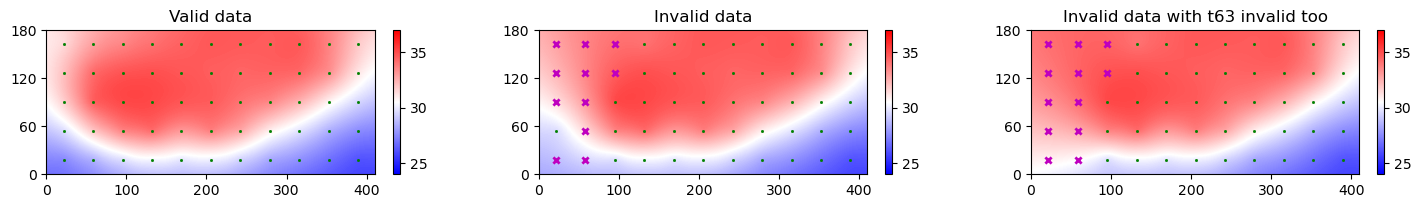

In [22]:
# For the same data, make two plots: one plot with t63 valid and one with t63 invalid (set it to -273.0):
df = pd.read_csv("/Users/cyrilmonette/Desktop/EPFL 2018-2026/PhD - Mobots/data/22.06-22.10_observation_BH/Thermal meas/abc01/abc01_tmp_2022-06-27.csv", parse_dates=['datetime'])
df.set_index('datetime', inplace=True)
print(df.head())
plt.figure(2); plt.clf()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 7))
temps = df.iloc[0][1:65]
temps_np = temps.to_numpy()
# in the first subplot, plot the valid data
hive = tu.ThermalFrame(temperature_data=temps_np, show_sensors=True)
hive.plot_thermal_field(ax[0],show_cb=True,v_min=24,v_max=37)
ax[0].set_title(f"Valid data")

# in the second subplot, plot the invalid data
temps_np[52:63] = -273.0
hive = tu.ThermalFrame(temperature_data=temps_np, show_sensors=True)
hive.plot_thermal_field(ax[1],show_cb=True,v_min=24,v_max=37)
ax[1].set_title(f"Invalid data")

# in the second subplot, plot the invalid data
temps_np[52:64] = -273.0
hive = tu.ThermalFrame(temperature_data=temps_np, show_sensors=True)
hive.plot_thermal_field(ax[2],show_cb=True,v_min=24,v_max=37)
ax[2].set_title(f"Invalid data with t63 invalid too")

